# Should we change the simulator to change the batch?

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

# Define repressilator model
def model(variables, t, params):

    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = params #only 2 ks are parameters to infer
    k3 = 246.96291990024542
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dm1dt = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dp1dt = (b1 * m1) - (dp1 * p1)
    dm2dt = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dp2dt = (b2 * m2) - (dp2 * p2)
    dm3dt = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dp3dt = (b3 * m3)-(dp3 * p3)
    
    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

# Define the true parameters for k
true_params = np.array([
    246.96291990024542, 246.96291990024542,])

# Establish prior from 0-250
num_dim = 2
prior = utils.BoxUniform(low=10**-2 * torch.ones(num_dim), high=250 * torch.ones(num_dim))

In [3]:

import warnings
from typing import Any, Callable, Dict, Optional, Sequence, Tuple, Union, cast

import torch
from numpy import ndarray
from pyknos.nflows import flows
from scipy.stats._distn_infrastructure import rv_frozen
from scipy.stats._multivariate import multi_rv_frozen
from torch import Tensor, float32, nn
from torch.distributions import Distribution, Uniform

from sbi.types import Array
from sbi.utils.sbiutils import warn_on_iid_x, within_support
from sbi.utils.torchutils import BoxUniform, atleast_2d
from sbi.utils.user_input_checks_utils import (
    CustomPriorWrapper,
    MultipleIndependent,
    PytorchReturnTypeWrapper,
    ScipyPytorchWrapper,
)

def ensure_batched_simulator(simulator: Callable, prior) -> Callable:
    """Return a simulator with batched output.

    Return the unchanged simulator if it can already simulate multiple parameter
    vectors per call. Otherwise, wrap as simulator with batched output (leading batch
    dimension of shape [1]).
    """

    is_batched_simulator = True
    try:
        batch_size = 2
        # The simulator must return a matching batch dimension and data.
        output_shape = simulator(prior.sample((batch_size,))).shape
        assert len(output_shape) > 1
        assert output_shape[0] == batch_size
    except Exception:
        is_batched_simulator = False

    return simulator if is_batched_simulator else get_batch_loop_simulator(simulator)

6000

In [2]:
# We define the time variable (0-100 in 1000 steps), the initial conditions, etc.
num_timesteps = 1000
num_trajectories = 6
initial_conditions = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_trajectories, num_timesteps))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[i, timestep] = solution[timestep][i]
    true_list = []
    for tra in traj: #Erase this loop if we want 6x1000
        for timepoint in tra:
            true_list.append(timepoint)
    true_tensor = torch.Tensor(true_list)
    return true_tensor

true_data = simulator(true_params)
true_data

tensor([  0.0000,   2.3466,   4.4394,  ..., 746.8439, 759.2465, 770.9217])

In [3]:
true_data.shape

torch.Size([6000])

BoxUniform(Uniform(low: torch.Size([2]), high: torch.Size([2])), 1)

In [15]:
batch_size = 2
prior.sample((batch_size,))

tensor([[162.0011, 109.5707],
        [ 35.1546,   7.2331]])

In [16]:
simulator(prior.sample((batch_size,)))

/project/home23/sg2023/Desktop/SBI/.conda/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:242: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

In [14]:
# Try function's workings
batch_size = 1
# The simulator must return a matching batch dimension and data.
simulator(prior.sample((batch_size,))).shape

ValueError: not enough values to unpack (expected 2, got 1)

# Change simulator?

In [27]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

# Define repressilator model
def model(variables, t, params):

    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = params #only 2 ks are parameters to infer
    k3 = 246.96291990024542
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dm1dt = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dp1dt = (b1 * m1) - (dp1 * p1)
    dm2dt = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dp2dt = (b2 * m2) - (dp2 * p2)
    dm3dt = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dp3dt = (b3 * m3) - (dp3 * p3)
    
    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

# Define the true parameters for k
true_params = np.array([
    246.96291990024542, 246.96291990024542,])

# Establish prior from 0-250
num_dim = 2
prior = utils.BoxUniform(low=10**-2 * torch.ones(num_dim), high=250 * torch.ones(num_dim))

In [38]:
full_tensor = torch.tensor([])
full_tensor_ext = torch.cat((full_tensor, torch.tensor([1,2])), dim = 0)
full_tensor_ext2 = torch.cat((full_tensor_ext, torch.tensor([1,2])), dim = 0)
full_tensor_ext2.shape

torch.Size([4])

In [39]:
import torch

# Existing tensor with batch size 3, each tensor with shape (2, 3)
existing_tensor = torch.tensor([[[1, 2, 3], [4, 5, 6]],
                                [[7, 8, 9], [10, 11, 12]],
                                [[13, 14, 15], [16, 17, 18]]])

# Data to append with batch size 1, each tensor with shape (2, 3)
new_data = torch.tensor([[[19, 20, 21], [22, 23, 24]]])

# Concatenate tensors along the batch dimension (dim=0)
appended_tensor = torch.cat((existing_tensor, new_data), dim=0)

print("Appended tensor:")
print(appended_tensor)


Appended tensor:
tensor([[[ 1,  2,  3],
         [ 4,  5,  6]],

        [[ 7,  8,  9],
         [10, 11, 12]],

        [[13, 14, 15],
         [16, 17, 18]],

        [[19, 20, 21],
         [22, 23, 24]]])


In [41]:
existing_tensor.shape

torch.Size([3, 2, 3])

In [47]:
full_tensor = torch.zeros((num_trajectories, num_timesteps)).unsqueeze(0)
full_tensor_one = torch.ones((num_trajectories, num_timesteps)).unsqueeze(0)
out = torch.cat((full_tensor, full_tensor_one), dim=0)
out.shape

torch.Size([2, 6, 1000])

In [48]:
out[1]

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [50]:
out.size(0)

2

In [5]:
# We define the time variable (0-100 in 1000 steps), the initial conditions, etc.
num_timesteps = 1000
num_trajectories = 6
initial_conditions = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    full_tensor = torch.zeros((num_trajectories * num_timesteps)).unsqueeze(0)
    if len(parameter_set) == 1:
        for params in parameter_set:
            solution = odeint(model, initial_conditions, t, args=(params,))
            traj = torch.zeros((num_trajectories, num_timesteps))
            for i in range(num_trajectories):
                for timestep in range(num_timesteps):
                    traj[i, timestep] = solution[timestep][i]
            true_list = []
            for tra in traj: #Erase this loop if we want 6x1000
                for timepoint in tra:
                    true_list.append(timepoint)
            true_tensor = torch.Tensor(true_list).unsqueeze(0)
            return true_tensor
    else:
        for params in parameter_set:
            solution = odeint(model, initial_conditions, t, args=(params,))
            traj = torch.zeros((num_trajectories, num_timesteps))
            for i in range(num_trajectories):
                for timestep in range(num_timesteps):
                    traj[i, timestep] = solution[timestep][i]
            true_list = []
            for tra in traj: #Erase this loop if we want 6x1000
                for timepoint in tra:
                    true_list.append(timepoint)
            true_tensor = torch.Tensor(true_list).unsqueeze(0)
            full_tensor = torch.cat((full_tensor, true_tensor), dim=0)
        n_sims = full_tensor.size(0)
        output_tensor = full_tensor[1:n_sims]
        return output_tensor


In [36]:
true_params = torch.tensor([
    246.96291990024542, 246.96291990024542,]).unsqueeze(0)
true_params.shape

torch.Size([1, 2])

In [37]:
len(true_params)

1

In [7]:
true_data = simulator(true_params)
true_data

tensor([[  0.0000,   2.3466,   4.4394,  ..., 746.8439, 759.2466, 770.9218]])

In [8]:
batch_size = 3
batch_params = prior.sample((batch_size,))
batch_params.shape

torch.Size([3, 2])

In [9]:
simulator(prior.sample((batch_size,))).shape

torch.Size([3, 6000])

In [90]:
simulator(prior.sample((batch_size,)))

tensor([[  0.0000,   2.3459,   4.3501,  ..., 609.4203, 580.2196, 551.4930],
        [  0.0000,   2.3466,   4.4394,  ...,  74.3807,  69.3614,  64.6759],
        [  0.0000,   2.3466,   4.4394,  ..., 360.3610, 339.5109, 319.5849]])

# simulator NOW HANDLES multiple param sets!

In [38]:
len(prior.sample((batch_size,)))

2

In [10]:
batch_size = 2
output_shape = simulator(prior.sample((batch_size,))).shape
output_shape

torch.Size([2, 6000])

In [13]:
len(output_shape) > 1

True

In [12]:
output_shape[0] == batch_size

True

# Add an input dimension of 1! for input_size to RNN of 1

In [19]:
# We define the time variable (0-100 in 1000 steps), the initial conditions, etc.
num_timesteps = 1000
num_trajectories = 6
initial_conditions = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    full_tensor = torch.zeros((num_trajectories * num_timesteps)).unsqueeze(0)
    if len(parameter_set) == 1:
        for params in parameter_set:
            solution = odeint(model, initial_conditions, t, args=(params,))
            traj = torch.zeros((num_trajectories, num_timesteps))
            for i in range(num_trajectories):
                for timestep in range(num_timesteps):
                    traj[i, timestep] = solution[timestep][i]
            true_list = []
            for tra in traj: #Erase this loop if we want 6x1000
                for timepoint in tra:
                    true_list.append(timepoint)
            true_tensor = torch.Tensor(true_list).unsqueeze(0)
            out = true_tensor.unsqueeze(-1)
            return out
    else:
        for params in parameter_set:
            solution = odeint(model, initial_conditions, t, args=(params,))
            traj = torch.zeros((num_trajectories, num_timesteps))
            for i in range(num_trajectories):
                for timestep in range(num_timesteps):
                    traj[i, timestep] = solution[timestep][i]
            true_list = []
            for tra in traj: #Erase this loop if we want 6x1000
                for timepoint in tra:
                    true_list.append(timepoint)
            true_tensor = torch.Tensor(true_list).unsqueeze(0)
            full_tensor = torch.cat((full_tensor, true_tensor), dim=0)
        n_sims = full_tensor.size(0)
        output_tensor = full_tensor[1:n_sims]
        out = output_tensor.unsqueeze(-1)
        return out


In [16]:
batch_size = 2
output_shape = simulator(prior.sample((batch_size,))).shape
output_shape

torch.Size([2, 6000, 1])

In [17]:
len(output_shape) > 1

True

In [18]:
output_shape[0] == batch_size

True

# BEWARE: this code is very unoptimised, just proof of concept

# Just try to optimise it a bit more...

In [33]:
# ODEINT will only output every timepoint...

def model(variables, t, params):

    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = params #only 2 ks are parameters to infer
    k3 = 246.96291990024542
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dm1dt = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dp1dt = (b1 * m1) - (dp1 * p1)
    dm2dt = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dp2dt = (b2 * m2) - (dp2 * p2)
    dm3dt = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dp3dt = (b3 * m3)-(dp3 * p3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

# Define the true parameters for k
true_params = torch.tensor([
    246.96291990024542, 246.96291990024542,]).unsqueeze(0)

# Establish prior from 0-250
num_dim = 2
prior = utils.BoxUniform(low=10**-2 * torch.ones(num_dim), high=250 * torch.ones(num_dim))

In [35]:
num_timesteps = 1000
num_trajectories = 6
initial_conditions = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)
true_params = np.array([
    246.96291990024542, 246.96291990024542,])
solution = odeint(model, initial_conditions, t, args=(true_params,))


In [41]:
true_params = torch.tensor([
    246.96291990024542, 246.96291990024542,]).unsqueeze(0)
for params in true_params:
    solution = odeint(model, initial_conditions, t, args=(params,))
solution

array([[  0.        ,   1.        ,   0.        ,   3.        ,
          0.        ,   2.        ],
       [  2.34660596,   4.86804386,   2.34660596,   6.71720504,
          2.34660602,   5.79262458],
       [  4.43943107,  15.65925914,   4.43943138,  17.36895799,
          4.43943165,  16.51410916],
       ...,
       [  0.94432372,  34.66929433,   1.98221318, 357.99256764,
         21.07125899, 746.84395033],
       [  1.20635405,  35.54361396,   1.77904717, 337.10655087,
         21.13892331, 759.24655958],
       [  1.54253261,  37.32369284,   1.59718083, 317.1699293 ,
         21.19924223, 770.92177284]])

# Torch?

In [44]:
from torchdiffeq import odeint

num_timesteps = 1000
num_trajectories = 6
initial_conditions = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)
true_params = np.array([
    246.96291990024542, 246.96291990024542,])
solution = odeint(model, initial_conditions, t, args=(true_params,))



TypeError: odeint() got an unexpected keyword argument 'args'

# Model with 1000x6

# Model with one parameter (flat) and optimised!

In [46]:
from scipy.integrate import odeint

In [2]:
def model(variables, t, params):

    m1, p1, m2, p2, m3, p3 = variables
    k1 = params #only 1
    k2 = k3 = 246.96291990024542
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dm1dt = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dp1dt = (b1 * m1) - (dp1 * p1)
    dm2dt = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dp2dt = (b2 * m2) - (dp2 * p2)
    dm3dt = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dp3dt = (b3 * m3)-(dp3 * p3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

# Define the true parameters for k
true_params = torch.tensor([
    246.96291990024542]).unsqueeze(0)

# Establish prior from 0-250
num_dim = 1
prior = utils.BoxUniform(low=10**-2 * torch.ones(num_dim), high=250 * torch.ones(num_dim))

# We define the time variable (0-100 in 1000 steps), the initial conditions, etc.
num_timesteps = 1000
num_trajectories = 6
initial_conditions = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    full_tensor = torch.zeros((num_trajectories * num_timesteps)).unsqueeze(0)
    if len(parameter_set) == 1:
        for params in parameter_set:
            solution = odeint(model, initial_conditions, t, args=(params,))
            transposed = list(map(list, zip(*solution)))
            tlist = []
            for species in transposed:
                for timestep in species:
                    tlist.append(timestep)
            true_tensor = torch.Tensor(tlist).unsqueeze(0)
            final_tensor = true_tensor.unsqueeze(-1)
            return final_tensor
    else:
        for params in parameter_set:
            solution = odeint(model, initial_conditions, t, args=(params,))
            transposed = list(map(list, zip(*solution)))
            tlist = []
            for species in transposed:
                for timestep in species:
                    tlist.append(timestep)
            true_tensor = torch.Tensor(tlist).unsqueeze(0)
            full_tensor = torch.cat((full_tensor, true_tensor), dim=0)
        n_sims = full_tensor.size(0)
        output_tensor = full_tensor[1:n_sims]
        out = output_tensor.unsqueeze(-1)
        return out

In [3]:
batch_size = 3
batch_params = prior.sample((batch_size,))
batch_params.shape

torch.Size([3, 1])

In [4]:
simulator(prior.sample((batch_size,))).shape

/project/home23/sg2023/Desktop/SBI/.conda/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:242: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,


torch.Size([3, 6000, 1])

In [75]:
simulator(prior.sample((batch_size,)))

tensor([[[  0.0000],
         [  2.3466],
         [  4.4333],
         ...,
         [461.5364],
         [436.0572],
         [411.5369]],

        [[  0.0000],
         [  2.3466],
         [  4.4394],
         ...,
         [835.2799],
         [815.2054],
         [792.6422]],

        [[  0.0000],
         [  2.3466],
         [  4.4393],
         ...,
         [469.9734],
         [495.0299],
         [519.2844]]])

# What if simulate for sbi could process parameter sets?

In [9]:
# Define repressilator model
def model(variables, t, params):

    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = params #only 2 ks are parameters to infer
    k3 = 246.96291990024542
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dm1dt = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dp1dt = (b1 * m1) - (dp1 * p1)
    dm2dt = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dp2dt = (b2 * m2) - (dp2 * p2)
    dm3dt = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dp3dt = (b3 * m3)-(dp3 * p3)
    
    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

# Define the true parameters for k
true_params = np.array([
    246.96291990024542, 246.96291990024542]).unsqueeze(0)

# Establish prior from 0-250
num_dim = 2
prior = utils.BoxUniform(low=10**-2 * torch.ones(num_dim), high=250 * torch.ones(num_dim))

# We define the time variable (0-100 in 1000 steps), the initial conditions, etc.
num_timesteps = 1000
num_trajectories = 6
initial_conditions = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    full_tensor = torch.zeros((num_trajectories * num_timesteps)).unsqueeze(0)
    if len(parameter_set) == 1:
        for params in parameter_set:
            solution = odeint(model, initial_conditions, t, args=(params,))
            transposed = list(map(list, zip(*solution)))
            tlist = []
            for species in transposed:
                for timestep in species:
                    tlist.append(timestep)
            true_tensor = torch.Tensor(tlist).unsqueeze(0)
            final_tensor = true_tensor.unsqueeze(-1)
            return final_tensor
    else:
        for params in parameter_set:
            solution = odeint(model, initial_conditions, t, args=(params,))
            transposed = list(map(list, zip(*solution)))
            tlist = []
            for species in transposed:
                for timestep in species:
                    tlist.append(timestep)
            true_tensor = torch.Tensor(tlist).unsqueeze(0)
            full_tensor = torch.cat((full_tensor, true_tensor), dim=0)
        n_sims = full_tensor.size(0)
        output_tensor = full_tensor[1:n_sims]
        out = output_tensor.unsqueeze(-1)
        return out

In [10]:
# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

In [11]:
batch_size = 4
# The simulator must return a matching batch dimension and data.
output_shape = simulator_wrapper(prior.sample((batch_size,))).shape
output_shape

torch.Size([4, 6000, 1])

In [7]:
fourdim = simulator_wrapper(prior.sample((batch_size,)))
fourdim.shape

torch.Size([4, 6000])

# Try fortran or numba to remove loops...

In [31]:
import numpy as np

def euler_method(func, y0, t, params):
    """
    Integrate a system of ODEs using Euler's method.

    Parameters:
        func : function
            A function representing the right-hand side of the system of ODEs.
            It must take three arguments: t (time), y (state), and params (parameters),
            and return the derivative of y as an array.
        y0 : array_like
            The initial condition on the state y at the initial time t0.
        t : array_like
            A sequence of time points for which to solve for y. The initial
            value point should be the first element of this sequence.
        params : array_like
            Parameters required by the ODE function.

    Returns:
        y : ndarray, shape (len(t), len(y0))
            Array containing the value of y for each desired time in t,
            with the initial value y0 in the first row.
    """
    num_eqns = len(y0)
    y = np.zeros((len(t), num_eqns))
    y[0] = y0
    dt = t[1] - t[0]
    for i in range(1, len(t)):
        y[i] = y[i - 1] + dt * func(t[i - 1], y[i - 1], params)
    return y

# Example function representing a system of ODEs with parameters
def system_of_odes(t, y, params):
    """
    Defines the system of ODEs to be integrated.

    Parameters:
        t : float
            The current time.
        y : array_like
            The current state of the system.
        params : array_like
            Parameters required by the ODE function.

    Returns:
        dydt : array_like
            The derivative of the state y at time t.
    """
    dydt = np.zeros_like(y)

    m1, p1, m2, p2, m3, p3 = y
    k1, k2 = params #only 2 ks are parameters to infer
    k3 = 246.96291990024542
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dydt[0] = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dydt[1] = (b1 * m1) - (dp1 * p1)
    dydt[2] = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dydt[3] = (b2 * m2) - (dp2 * p2)
    dydt[4] = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dydt[5] = (b3 * m3)-(dp3 * p3)
    
    return dydt

# Initial conditions
true_params = np.array([
    246.96291990024542, 246.96291990024542])
num_timesteps = 1000
num_trajectories = 6
y0 = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

# Integrate the system of ODEs using Euler's method
y = euler_method(system_of_odes, y0, t, true_params)

print(y)


[[0.00000000e+00 1.00000000e+00 0.00000000e+00 3.00000000e+00
  0.00000000e+00 2.00000000e+00]
 [2.48345715e+00 9.21584939e-01 2.48345715e+00 2.76475482e+00
  2.48345715e+00 1.84316988e+00]
 [4.68267105e+00 9.25754324e+00 4.68267105e+00 1.09561808e+01
  4.68267105e+00 1.01068620e+01]
 ...
 [2.34872336e-01 9.55966108e+01 1.63505152e+01 8.63828747e+02
  1.63190425e+01 3.31278268e+02]
 [2.15210480e-01 8.88956025e+01 1.49459389e+01 8.51449394e+02
  1.69133336e+01 3.60552336e+02]
 [1.98152246e-01 8.26534851e+01 1.35628466e+01 8.35285304e+02
  1.74460787e+01 3.89542964e+02]]


In [16]:
y.shape

(1000, 6)

In [25]:
y_transposed = y.T

# Flatten and concatenate the trajectories
concatenated_trajectories = y_transposed.flatten()

concatenated_trajectories.shape

(6000,)

In [27]:
yt = torch.tensor(concatenated_trajectories)
yt

tensor([  0.0000,   2.4835,   4.6827,  ..., 331.2783, 360.5523, 389.5430],
       dtype=torch.float64)

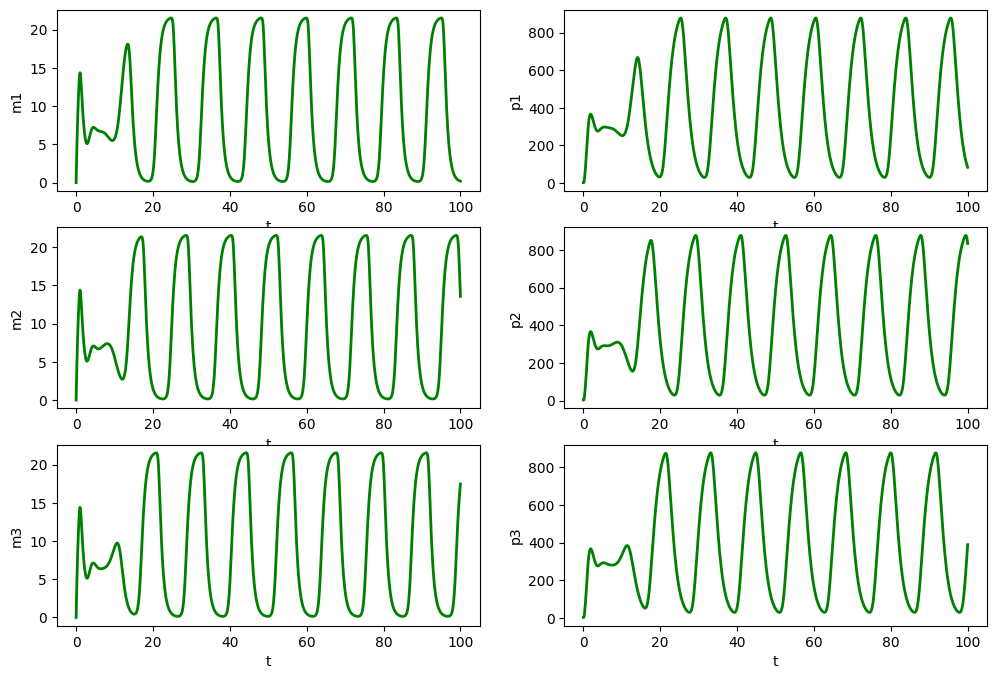

In [29]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
axs = axs.flatten()

variable_labels = ['m1', 'p1', 'm2', 'p2', 'm3', 'p3']
for i in range(6):
    axs[i].plot(t, y[:, i], linewidth=2, color = "green")
    axs[i].set_xlabel('t')
    axs[i].set_ylabel(variable_labels[i])

# A new integration method...


In [52]:
pip install numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 27.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 14.2 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [53]:
import numpy as np
from numba import jit

@jit
def euler_method(func, y0, t, params):
    num_eqns = len(y0)
    y = np.zeros((len(t), num_eqns))
    y[0] = y0
    dt = t[1] - t[0]
    for i in range(1, len(t)):
        y[i] = y[i - 1] + dt * func(t[i - 1], y[i - 1], params)
    return y

# Example function representing a system of ODEs with parameters
@jit
def system_of_odes(t, y, params):
    dydt = np.zeros_like(y)

    m1, p1, m2, p2, m3, p3 = y
    k1, k2 = params #only 2 ks are parameters to infer
    k3 = 246.96291990024542
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dydt[0] = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dydt[1] = (b1 * m1) - (dp1 * p1)
    dydt[2] = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dydt[3] = (b2 * m2) - (dp2 * p2)
    dydt[4] = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dydt[5] = (b3 * m3)-(dp3 * p3)
    
    return dydt

# Initial conditions
true_params = np.array([
    246.96291990024542, 246.96291990024542])
num_timesteps = 1000
num_trajectories = 6
y0 = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

# Integrate the system of ODEs using Euler's method
y = euler_method(system_of_odes, y0, t, true_params) #6x1000

#Now if we want to flatten it...
y_transposed = y.T
concatenated_trajectories = y_transposed.flatten()
yt = torch.tensor(concatenated_trajectories)
yt.shape

torch.Size([6000])

In [35]:
yt.unsqueeze(0).unsqueeze(-1).shape

torch.Size([1, 6000, 1])

### Simulator and prior...

In [54]:
num_dim = 2
prior = utils.BoxUniform(low=10**-2 * torch.ones(num_dim), high=250 * torch.ones(num_dim))

In [55]:
def simulator(parameter_set):
    full_tensor = torch.zeros((num_trajectories * num_timesteps)).unsqueeze(0)
    if len(parameter_set) == 1:
        for params in parameter_set:
            y = euler_method(system_of_odes, y0, t, params)
            y_transposed = y.T
            concatenated_trajectories = y_transposed.flatten()
            yt = torch.tensor(concatenated_trajectories)
            final_tensor = yt.unsqueeze(0).unsqueeze(-1)
            return final_tensor
    else:
        for params in parameter_set:
            y = euler_method(system_of_odes, y0, t, params)
            y_transposed = y.T
            concatenated_trajectories = y_transposed.flatten()
            yt = torch.tensor(concatenated_trajectories)
            true_tensor = yt.unsqueeze(0)
            full_tensor = torch.cat((full_tensor, true_tensor), dim=0)
        n_sims = full_tensor.size(0)
        output_tensor = full_tensor[1:n_sims]
        out = output_tensor.unsqueeze(-1)
        return out
    
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
During: typing of argument at /tmp/ipykernel_1876419/2889089032.py (4)

File "../../../../../../../tmp/ipykernel_1876419/2889089032.py", line 4:
<source missing, REPL/exec in use?> 

This error may have been caused by the following argument(s):
- argument 3: Cannot determine Numba type of <class 'torch.Tensor'> 

This error may have been caused by the following argument(s):
- argument 3: Cannot determine Numba type of <class 'torch.Tensor'>


In [47]:
true_params = torch.tensor([
    246.96291990024542, 246.96291990024542]).unsqueeze(0)
true_data = simulator_wrapper(true_params)
true_data.shape

torch.Size([1, 6000, 1])

In [49]:
batch_size = 4
fourdim = simulator_wrapper(prior.sample((batch_size,)))
fourdim.shape

torch.Size([4, 6000, 1])

In [50]:
fourdim

tensor([[[  0.0000],
         [  2.4835],
         [  4.6827],
         ...,
         [ 46.2457],
         [ 42.9876],
         [ 39.9631]],

        [[  0.0000],
         [  2.4835],
         [  4.6827],
         ...,
         [ 15.7410],
         [ 19.7048],
         [ 24.9628]],

        [[  0.0000],
         [  2.4834],
         [  4.6826],
         ...,
         [841.9395],
         [848.7794],
         [855.1519]],

        [[  0.0000],
         [  2.4835],
         [  4.6827],
         ...,
         [ 35.6827],
         [ 33.2882],
         [ 31.1089]]])

# New simulator with odeint for final runs

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np

# Old simulator without loops...
def model(variables, t, params):

    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params #only 3 ks are parameters to infer
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dm1dt = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dp1dt = (b1 * m1) - (dp1 * p1)
    dm2dt = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dp2dt = (b2 * m2) - (dp2 * p2)
    dm3dt = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dp3dt = (b3 * m3)-(dp3 * p3)
    
    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

# Initial conditions
true_params = torch.tensor([
    246.96291990024542, 246.96291990024542, 246.96291990024542]).unsqueeze(0)
num_timesteps = 1000
num_trajectories = 6
y0 = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

In [9]:
true_params[0]

tensor([246.9629, 246.9629, 246.9629])

In [10]:
y = odeint(model, y0, t, args=(true_params[0],))
y

array([[  0.        ,   1.        ,   0.        ,   3.        ,
          0.        ,   2.        ],
       [  2.34660597,   4.86804387,   2.34660597,   6.71720504,
          2.34660597,   5.79262445],
       [  4.43943113,  15.65925887,   4.43943139,  17.36895764,
          4.43943154,  16.51410845],
       ...,
       [  0.94432564,  34.66929893,   1.98221117, 357.99238622,
         21.07125964, 746.84406369],
       [  1.20635659,  35.54362567,   1.77904538, 337.10637695,
         21.13892389, 759.24666632],
       [  1.54253586,  37.3237132 ,   1.59717924, 317.16976299,
         21.19924286, 770.9218733 ]])

In [11]:
y_transposed = y.T
concatenated_trajectories = y_transposed.flatten()
yt = torch.tensor(concatenated_trajectories)
final_tensor = yt.unsqueeze(0).unsqueeze(-1)
final_tensor

tensor([[[  0.0000],
         [  2.3466],
         [  4.4394],
         ...,
         [746.8441],
         [759.2467],
         [770.9219]]], dtype=torch.float64)

In [12]:
final_tensor.shape

torch.Size([1, 6000, 1])

In [13]:
# So, simulator:
def simulator(parameter_set):
    full_tensor = torch.zeros((num_trajectories * num_timesteps)).unsqueeze(0)
    if len(parameter_set) == 1:
        for params in parameter_set:
            y = odeint(model, y0, t, args=(params,))
            y_transposed = y.T
            concatenated_trajectories = y_transposed.flatten()
            yt = torch.tensor(concatenated_trajectories)
            final_tensor = yt.unsqueeze(0).unsqueeze(-1)
            return final_tensor
    else:
        for params in parameter_set:
            y = odeint(model, y0, t, args=(params,))
            y_transposed = y.T
            concatenated_trajectories = y_transposed.flatten()
            yt = torch.tensor(concatenated_trajectories)
            true_tensor = yt.unsqueeze(0)
            full_tensor = torch.cat((full_tensor, true_tensor), dim=0)
        n_sims = full_tensor.size(0)
        output_tensor = full_tensor[1:n_sims]
        out = output_tensor.unsqueeze(-1)
        return out

In [16]:
num_dim = 3
prior = utils.BoxUniform(low=10**-2 * torch.ones(num_dim), high=250 * torch.ones(num_dim))
true_params = [
    246.96291990024542, 246.96291990024542, 246.96291990024542]
true_data = simulator(torch.tensor(true_params).unsqueeze(0))

In [17]:
# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)
batch_size = 4
# The simulator must return a matching batch dimension and data.
output_shape = simulator_wrapper(prior.sample((batch_size,))).shape
output_shape

torch.Size([4, 6000, 1])

In [18]:
simulator_wrapper(prior.sample((batch_size,)))

tensor([[[  0.0000],
         [  2.3466],
         [  4.4394],
         ...,
         [297.3374],
         [325.6540],
         [353.9074]],

        [[  0.0000],
         [  2.3466],
         [  4.4394],
         ...,
         [484.9734],
         [509.6827],
         [533.5342]],

        [[  0.0000],
         [  2.3466],
         [  4.4379],
         ...,
         [ 84.0952],
         [ 78.2902],
         [ 72.8725]],

        [[  0.0000],
         [  2.3466],
         [  4.4394],
         ...,
         [ 27.2984],
         [ 25.5286],
         [ 23.9290]]])

In [19]:
simulator(prior.sample((batch_size,)))

tensor([[[  0.0000],
         [  2.3466],
         [  4.4394],
         ...,
         [  3.9826],
         [  3.7566],
         [  3.5474]],

        [[  0.0000],
         [  2.3466],
         [  4.4322],
         ...,
         [107.9201],
         [100.5449],
         [ 93.6511]],

        [[  0.0000],
         [  2.3466],
         [  4.4394],
         ...,
         [  7.4462],
         [  6.9657],
         [  6.5204]],

        [[  0.0000],
         [  2.3466],
         [  4.4394],
         ...,
         [469.4419],
         [444.6228],
         [420.5800]]], dtype=torch.float64)

check device

In [20]:
##### cuda and device #####

import torch

# Check if GPU is available
if torch.cuda.is_available():
    # Set the device to GPU
    device = torch.device("cuda")
    # This will make sure that tensors and models created will be moved to GPU
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

GPU is not available. Using CPU.


# Test whether a simulator is faster than another...

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np

# Old simulator without loops...
def model(variables, t, params):

    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params #only 3 ks are parameters to infer
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dm1dt = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dp1dt = (b1 * m1) - (dp1 * p1)
    dm2dt = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dp2dt = (b2 * m2) - (dp2 * p2)
    dm3dt = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dp3dt = (b3 * m3)-(dp3 * p3)
    
    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

# Initial conditions
true_params = [246.96291990024542, 246.96291990024542, 246.96291990024542]
num_timesteps = 100
num_trajectories = 6
y0 = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(params):
    y = odeint(model, y0, t, args=(params,))
    return torch.tensor(y, dtype=torch.float32).flatten()


num_dim = 3
prior = utils.BoxUniform(low=10**-2 * torch.ones(num_dim), high=250 * torch.ones(num_dim))


In [2]:
true_data = simulator(true_params)

In [6]:
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

torch.Size([3, 600])

In [7]:
batch_size = 3
test3d = simulator_wrapper(prior.sample((batch_size,)))
test3d.shape

torch.Size([3, 600])

### Try something else...

In [16]:
def simulator(params):
    y = odeint(model, y0, t, args=(params,))
    return torch.tensor(y, dtype=torch.float32).flatten()
true_data = simulator(true_params)
true_data.view(100,6).T.shape


torch.Size([6, 100])

In [17]:
def simulator(params):
    y = odeint(model, y0, t, args=(params,))
    traj = torch.tensor(y, dtype=torch.float32).flatten()
    return traj.view(100,6).T
true_data = simulator(true_params)

In [20]:
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

In [21]:
batch_size = 3
test3d = simulator_wrapper(prior.sample((batch_size,)))
test3d.shape

torch.Size([3, 6, 100])

# is it the simulator or is it the batching that slows things down?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np
def model(variables, t, params):

    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params #only 3 ks are parameters to infer
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dm1dt = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dp1dt = (b1 * m1) - (dp1 * p1)
    dm2dt = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dp2dt = (b2 * m2) - (dp2 * p2)
    dm3dt = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dp3dt = (b3 * m3)-(dp3 * p3)
    
    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

# Initial conditions
true_params = [
    246.96291990024542, 246.96291990024542, 246.96291990024542]
num_timesteps = 100
num_trajectories = 6
y0 = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

In [5]:
test = odeint(model, y0, t, args=(true_params,))
y_transposed = test.T
concatenated_trajectories = y_transposed.flatten()
yt = torch.tensor(concatenated_trajectories)
final_tensor = yt.unsqueeze(0).unsqueeze(-1)

In [7]:
final_tensor

tensor([[[0.0000e+00],
         [1.3497e+01],
         [7.5902e+00],
         [5.6527e+00],
         [6.7397e+00],
         [7.0145e+00],
         [6.7590e+00],
         [6.4194e+00],
         [5.9419e+00],
         [5.8136e+00],
         [7.1129e+00],
         [1.0784e+01],
         [1.4706e+01],
         [1.3049e+01],
         [5.6265e+00],
         [1.9637e+00],
         [6.8870e-01],
         [2.8788e-01],
         [4.7755e-01],
         [4.3708e+00],
         [1.4189e+01],
         [1.9242e+01],
         [2.0921e+01],
         [2.1440e+01],
         [1.6333e+01],
         [5.9376e+00],
         [1.9835e+00],
         [6.7987e-01],
         [2.5967e-01],
         [2.0761e-01],
         [1.4329e+00],
         [9.6609e+00],
         [1.7470e+01],
         [2.0351e+01],
         [2.1273e+01],
         [2.0953e+01],
         [1.0082e+01],
         [3.4112e+00],
         [1.1466e+00],
         [4.0782e-01],
         [1.8936e-01],
         [4.4432e-01],
         [4.5466e+00],
         [1

In [8]:
def simulator(parameter_set):
    full_tensor = torch.zeros((num_trajectories * num_timesteps)).unsqueeze(0)
    if len(parameter_set) == 1:
        for params in parameter_set:
            y = odeint(model, y0, t, args=(params,))
            y_transposed = y.T
            concatenated_trajectories = y_transposed.flatten()
            yt = torch.tensor(concatenated_trajectories)
            final_tensor = yt.unsqueeze(0).unsqueeze(-1)
            return final_tensor
    else:
        for params in parameter_set:
            y = odeint(model, y0, t, args=(params,))
            y_transposed = y.T
            concatenated_trajectories = y_transposed.flatten()
            yt = torch.tensor(concatenated_trajectories)
            true_tensor = yt.unsqueeze(0)
            full_tensor = torch.cat((full_tensor, true_tensor), dim=0)
        n_sims = full_tensor.size(0)
        output_tensor = full_tensor[1:n_sims]
        out = output_tensor.unsqueeze(-1)
        return out
    
num_dim = 3
prior = utils.BoxUniform(low=10**-2 * torch.ones(num_dim), high=250 * torch.ones(num_dim))
true_data = simulator(torch.tensor(true_params).unsqueeze(0))

In [9]:
batch_size = 3
fourdim = simulator(prior.sample((batch_size,)))
fourdim.shape

torch.Size([3, 600, 1])

In [10]:
simulator(torch.tensor(true_params).unsqueeze(0))

tensor([[[0.0000e+00],
         [1.3497e+01],
         [7.5902e+00],
         [5.6527e+00],
         [6.7397e+00],
         [7.0145e+00],
         [6.7590e+00],
         [6.4194e+00],
         [5.9419e+00],
         [5.8136e+00],
         [7.1129e+00],
         [1.0784e+01],
         [1.4706e+01],
         [1.3049e+01],
         [5.6265e+00],
         [1.9637e+00],
         [6.8869e-01],
         [2.8788e-01],
         [4.7757e-01],
         [4.3709e+00],
         [1.4189e+01],
         [1.9242e+01],
         [2.0921e+01],
         [2.1440e+01],
         [1.6333e+01],
         [5.9375e+00],
         [1.9835e+00],
         [6.7986e-01],
         [2.5967e-01],
         [2.0761e-01],
         [1.4329e+00],
         [9.6611e+00],
         [1.7470e+01],
         [2.0351e+01],
         [2.1273e+01],
         [2.0953e+01],
         [1.0082e+01],
         [3.4112e+00],
         [1.1465e+00],
         [4.0782e-01],
         [1.8935e-01],
         [4.4433e-01],
         [4.5467e+00],
         [1

In [12]:
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)


In [13]:
fourdim = simulator_wrapper(prior.sample((batch_size,)))
fourdim.shape

torch.Size([3, 600, 1])

In [16]:
#same but euler...
def euler_method(func, y0, t, params):
    num_eqns = len(y0)
    y = np.zeros((len(t), num_eqns))
    y[0] = y0
    dt = t[1] - t[0]
    for i in range(1, len(t)):
        y[i] = y[i - 1] + dt * func(t[i - 1], y[i - 1], params)
    return y

# Example function representing a system of ODEs with parameters
def system_of_odes(t, y, params):
    dydt = np.zeros_like(y)

    m1, p1, m2, p2, m3, p3 = y
    k1, k2, k3 = params #only 3 ks are parameters to infer
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dydt[0] = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dydt[1] = (b1 * m1) - (dp1 * p1)
    dydt[2] = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dydt[3] = (b2 * m2) - (dp2 * p2)
    dydt[4] = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dydt[5] = (b3 * m3)-(dp3 * p3)
    
    return dydt

# Initial conditions
true_params = [
    246.96291990024542, 246.96291990024542, 246.96291990024542]
num_timesteps = 100
num_trajectories = 6
y0 = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    full_tensor = torch.zeros((num_trajectories * num_timesteps)).unsqueeze(0)
    if len(parameter_set) == 1:
        for params in parameter_set:
            y = euler_method(system_of_odes, y0, t, params)
            y_transposed = y.T
            concatenated_trajectories = y_transposed.flatten()
            yt = torch.tensor(concatenated_trajectories)
            final_tensor = yt.unsqueeze(0).unsqueeze(-1)
            return final_tensor
    else:
        for params in parameter_set:
            y = euler_method(system_of_odes, y0, t, params)
            y_transposed = y.T
            concatenated_trajectories = y_transposed.flatten()
            yt = torch.tensor(concatenated_trajectories)
            true_tensor = yt.unsqueeze(0)
            full_tensor = torch.cat((full_tensor, true_tensor), dim=0)
        n_sims = full_tensor.size(0)
        output_tensor = full_tensor[1:n_sims]
        out = output_tensor.unsqueeze(-1)
        return out

In [17]:
true_data = simulator(torch.tensor(true_params).unsqueeze(0))
true_data.shape

torch.Size([1, 600, 1])

In [18]:
batch_size = 3
fourdim = simulator(prior.sample((batch_size,)))
fourdim.shape

torch.Size([3, 600, 1])

In [19]:
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

fourdim = simulator_wrapper(prior.sample((batch_size,)))
fourdim.shape

torch.Size([3, 600, 1])

## Athos's

In [ ]:
headers = ["k1" , "k2"]          # parameters to be inferred
num_timesteps = 100

# FOR SNLE
prior_min = 0.01                        # same for all parameters
prior_max = 250    

t = np.linspace(0, 100, num_timesteps)

param_dict = {'k1': 246.96291990024542, 'k2': 246.96291990024542, 'k3': 246.96291990024542, 'n1': 5, 'n2': 5, 'n3': 5, 'dm1': 1.143402097500176, 'dm2': 1.143402097500176, 'dm3': 1.143402097500176, 'dp1': 0.7833664565550977, 'dp2': 0.7833664565550977, 'dp3': 0.7833664565550977,
              'a1': 24.78485282457379, 'a2': 24.78485282457379, 'a3': 24.78485282457379, 'g1': 0.024884149937163258, 'g2': 0.024884149937163258, 'g3': 0.024884149937163258, 'b1': 33.82307682700831, 'b2': 33.82307682700831, 'b3': 33.82307682700831}

all_params = 'a1', 'a2', 'a3', 'g1', 'g2', 'g3', 'dm1', 'dm2', 'dm3', 'dp1', 'dp2', 'dp3', 'b1', 'b2', 'b3', 'n1', 'n2', 'n3', 'k1', 'k2', 'k3'
new_param_dict ={}
for param in all_params:
    if param not in headers:
        new_param_dict[param] = param_dict[param]
    elif param in headers:
        new_param_dict[param] = param

def my_simulator(theta):
    def model(variables, t, theta, new_param_dict = new_param_dict):
        m1, p1, m2, p2, m3, p3 = variables
        for i in range(len(headers)):
            new_param_dict[headers[i]] = theta[i]
        
        dm1dt = -new_param_dict['dm1']*m1 + (new_param_dict['a1'] / (1 + ((1/new_param_dict['k1']) * p2)**new_param_dict['n1'])) + new_param_dict['g1']
        dp1dt = (new_param_dict['b1']*m1) - (new_param_dict['dp1']*p1)
        dm2dt = -new_param_dict['dm2']*m2 + (new_param_dict['a2'] / (1 + ((1/new_param_dict['k2']) * p3)**new_param_dict['n2'])) + new_param_dict['g2']
        dp2dt = (new_param_dict['b2']*m2) - (new_param_dict['dp2']*p2)
        dm3dt = -new_param_dict['dm3']*m3 + (new_param_dict['a3'] / (1 + ((1/new_param_dict['k3']) * p1)**new_param_dict['n3'])) + new_param_dict['g3']
        dp3dt = (new_param_dict['b3']*m3) - (new_param_dict['dp3']*p3)

        return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

    def solve_ode(theta, t):
        initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
        solution = odeint(model, initial_conditions, t, args=(theta, new_param_dict,))
        return torch.tensor(solution, dtype=torch.float32).flatten() # Flatten tensor to size [600]
    return solve_ode(theta, t)

def unflatten(solution):
    variables = ['m1', 'p1', 'm2', 'p2', 'm3', 'p3']
    solution_unflattened = torch.zeros((num_timesteps, len(variables)))
    for timestep in range(num_timesteps):
        for variable_idx, variable in enumerate(variables):
            solution_unflattened[timestep, variable_idx]=solution[timestep+variable_idx]
    return solution_unflattened

true_params = tuple(param_dict[parameter] for parameter in headers)
true_solutions = my_simulator(true_params)
true_solutions_unflattened = unflatten(true_solutions)

# Initial conditions
true_params = [
    246.96291990024542, 246.96291990024542, 246.96291990024542]
num_timesteps = 100
num_trajectories = 6
y0 = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

#### this above is flattened... 6s for 3 simulations

In [3]:
headers = ["k1" , "k2", "k3"]          # parameters to be inferred
num_timesteps = 100

# FOR SNLE
prior_min = 0.01                        # same for all parameters
prior_max = 250    

t = np.linspace(0, 100, num_timesteps)

param_dict = {'k1': 246.96291990024542, 'k2': 246.96291990024542, 'k3': 246.96291990024542, 'n1': 5, 'n2': 5, 'n3': 5, 'dm1': 1.143402097500176, 'dm2': 1.143402097500176, 'dm3': 1.143402097500176, 'dp1': 0.7833664565550977, 'dp2': 0.7833664565550977, 'dp3': 0.7833664565550977,
              'a1': 24.78485282457379, 'a2': 24.78485282457379, 'a3': 24.78485282457379, 'g1': 0.024884149937163258, 'g2': 0.024884149937163258, 'g3': 0.024884149937163258, 'b1': 33.82307682700831, 'b2': 33.82307682700831, 'b3': 33.82307682700831}

all_params = 'a1', 'a2', 'a3', 'g1', 'g2', 'g3', 'dm1', 'dm2', 'dm3', 'dp1', 'dp2', 'dp3', 'b1', 'b2', 'b3', 'n1', 'n2', 'n3', 'k1', 'k2', 'k3'
new_param_dict ={}
for param in all_params:
    if param not in headers:
        new_param_dict[param] = param_dict[param]
    elif param in headers:
        new_param_dict[param] = param

def my_simulator(theta):
    def model(variables, t, theta, new_param_dict = new_param_dict):
        m1, p1, m2, p2, m3, p3 = variables
        for i in range(len(headers)):
            new_param_dict[headers[i]] = theta[i]
        
        dm1dt = -new_param_dict['dm1']*m1 + (new_param_dict['a1'] / (1 + ((1/new_param_dict['k1']) * p2)**new_param_dict['n1'])) + new_param_dict['g1']
        dp1dt = (new_param_dict['b1']*m1) - (new_param_dict['dp1']*p1)
        dm2dt = -new_param_dict['dm2']*m2 + (new_param_dict['a2'] / (1 + ((1/new_param_dict['k2']) * p3)**new_param_dict['n2'])) + new_param_dict['g2']
        dp2dt = (new_param_dict['b2']*m2) - (new_param_dict['dp2']*p2)
        dm3dt = -new_param_dict['dm3']*m3 + (new_param_dict['a3'] / (1 + ((1/new_param_dict['k3']) * p1)**new_param_dict['n3'])) + new_param_dict['g3']
        dp3dt = (new_param_dict['b3']*m3) - (new_param_dict['dp3']*p3)

        return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

    def solve_ode(theta, t):
        initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
        y = odeint(model, initial_conditions, t, args=(theta,))
        y_transposed = y.T
        concatenated_trajectories = y_transposed.flatten()
        return torch.tensor(concatenated_trajectories, dtype=torch.float32)
    return solve_ode(theta, t)

def unflatten(solution):
    variables = ['m1', 'p1', 'm2', 'p2', 'm3', 'p3']
    solution_unflattened = torch.zeros((num_timesteps, len(variables)))
    for timestep in range(num_timesteps):
        for variable_idx, variable in enumerate(variables):
            solution_unflattened[timestep, variable_idx]=solution[timestep+variable_idx]
    return solution_unflattened

true_params = tuple(param_dict[parameter] for parameter in headers)
true_solutions = my_simulator(true_params)
true_solutions_unflattened = unflatten(true_solutions)

# Initial conditions
true_params = [
    246.96291990024542, 246.96291990024542, 246.96291990024542]
num_timesteps = 100
num_trajectories = 6
y0 = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

num_dim = len(true_params)
prior = utils.BoxUniform(low=prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))

In [4]:
simulator_wrapper, prior = prepare_for_sbi(my_simulator, prior)

In [5]:
fourdim = simulator_wrapper(prior.sample((3,)))
fourdim.shape

torch.Size([3, 600])

# Try to implement batch size and handle batches of parameters

In [13]:
headers = ["k1" , "k2", "k3"]          # parameters to be inferred
num_timesteps = 100

# FOR SNLE
prior_min = 0.01                        # same for all parameters
prior_max = 250    

t = np.linspace(0, 100, num_timesteps)

param_dict = {'k1': 246.96291990024542, 'k2': 246.96291990024542, 'k3': 246.96291990024542, 'n1': 5, 'n2': 5, 'n3': 5, 'dm1': 1.143402097500176, 'dm2': 1.143402097500176, 'dm3': 1.143402097500176, 'dp1': 0.7833664565550977, 'dp2': 0.7833664565550977, 'dp3': 0.7833664565550977,
              'a1': 24.78485282457379, 'a2': 24.78485282457379, 'a3': 24.78485282457379, 'g1': 0.024884149937163258, 'g2': 0.024884149937163258, 'g3': 0.024884149937163258, 'b1': 33.82307682700831, 'b2': 33.82307682700831, 'b3': 33.82307682700831}

all_params = 'a1', 'a2', 'a3', 'g1', 'g2', 'g3', 'dm1', 'dm2', 'dm3', 'dp1', 'dp2', 'dp3', 'b1', 'b2', 'b3', 'n1', 'n2', 'n3', 'k1', 'k2', 'k3'
new_param_dict ={}
for param in all_params:
    if param not in headers:
        new_param_dict[param] = param_dict[param]
    elif param in headers:
        new_param_dict[param] = param

def my_simulator(theta):
    def model(variables, t, theta, new_param_dict = new_param_dict):
        m1, p1, m2, p2, m3, p3 = variables
        for i in range(len(headers)):
            new_param_dict[headers[i]] = theta[i]
        
        dm1dt = -new_param_dict['dm1']*m1 + (new_param_dict['a1'] / (1 + ((1/new_param_dict['k1']) * p2)**new_param_dict['n1'])) + new_param_dict['g1']
        dp1dt = (new_param_dict['b1']*m1) - (new_param_dict['dp1']*p1)
        dm2dt = -new_param_dict['dm2']*m2 + (new_param_dict['a2'] / (1 + ((1/new_param_dict['k2']) * p3)**new_param_dict['n2'])) + new_param_dict['g2']
        dp2dt = (new_param_dict['b2']*m2) - (new_param_dict['dp2']*p2)
        dm3dt = -new_param_dict['dm3']*m3 + (new_param_dict['a3'] / (1 + ((1/new_param_dict['k3']) * p1)**new_param_dict['n3'])) + new_param_dict['g3']
        dp3dt = (new_param_dict['b3']*m3) - (new_param_dict['dp3']*p3)

        return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

    def solve_ode(theta, t):
        initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
        y = odeint(model, initial_conditions, t, args=(theta,))
        y_transposed = y.T
        concatenated_trajectories = y_transposed.flatten()
        yt = torch.tensor(concatenated_trajectories, dtype=torch.float32)
        return yt.unsqueeze(-1)
    return solve_ode(theta, t)

def unflatten(solution):
    variables = ['m1', 'p1', 'm2', 'p2', 'm3', 'p3']
    solution_unflattened = torch.zeros((num_timesteps, len(variables)))
    for timestep in range(num_timesteps):
        for variable_idx, variable in enumerate(variables):
            solution_unflattened[timestep, variable_idx]=solution[timestep+variable_idx]
    return solution_unflattened

true_params = tuple(param_dict[parameter] for parameter in headers)
true_solutions = my_simulator(true_params)
true_solutions_unflattened = unflatten(true_solutions)

# Initial conditions
true_params = [
    246.96291990024542, 246.96291990024542, 246.96291990024542]
num_timesteps = 100
num_trajectories = 6
y0 = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

num_dim = len(true_params)
prior = utils.BoxUniform(low=prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))

In [14]:
true_data = my_simulator(true_params)
true_data.shape

torch.Size([600, 1])

In [15]:
true_data

tensor([[0.0000e+00],
        [1.3526e+01],
        [7.6325e+00],
        [5.6702e+00],
        [6.6545e+00],
        [6.7551e+00],
        [6.4568e+00],
        [6.5260e+00],
        [7.1227e+00],
        [8.2339e+00],
        [8.8624e+00],
        [6.8761e+00],
        [3.4132e+00],
        [1.4284e+00],
        [8.6917e-01],
        [2.8091e+00],
        [1.1520e+01],
        [1.8181e+01],
        [2.0578e+01],
        [2.1339e+01],
        [1.8463e+01],
        [7.1709e+00],
        [2.4005e+00],
        [8.1605e-01],
        [3.0199e-01],
        [1.8888e-01],
        [9.4479e-01],
        [7.8435e+00],
        [1.6591e+01],
        [2.0063e+01],
        [2.1182e+01],
        [2.1348e+01],
        [1.1975e+01],
        [4.1043e+00],
        [1.3745e+00],
        [4.8173e-01],
        [2.0443e-01],
        [3.2122e-01],
        [3.1953e+00],
        [1.2993e+01],
        [1.8813e+01],
        [2.0785e+01],
        [2.1406e+01],
        [1.8320e+01],
        [7.0467e+00],
        [2

In [10]:
simulator_wrapper, prior = prepare_for_sbi(my_simulator, prior)

In [11]:
fourdim = simulator_wrapper(prior.sample((3,)))
fourdim.shape

torch.Size([3, 600, 1])

In [12]:
fourdim[0]

tensor([[0.0000e+00],
        [1.3847e+01],
        [1.7579e+01],
        [2.0118e+01],
        [2.1182e+01],
        [2.1535e+01],
        [2.1647e+01],
        [2.0475e+01],
        [7.3096e+00],
        [2.3225e+00],
        [7.4731e-01],
        [2.5117e-01],
        [1.0276e-01],
        [2.4019e-01],
        [3.9030e+00],
        [1.4178e+01],
        [1.9261e+01],
        [2.0929e+01],
        [2.1456e+01],
        [2.1622e+01],
        [2.1674e+01],
        [2.1690e+01],
        [1.6010e+01],
        [5.1623e+00],
        [1.6434e+00],
        [5.3318e-01],
        [1.8429e-01],
        [9.3354e-02],
        [5.3654e-01],
        [6.8799e+00],
        [1.6230e+01],
        [1.9952e+01],
        [2.1147e+01],
        [2.1525e+01],
        [2.1643e+01],
        [2.1681e+01],
        [2.1684e+01],
        [1.1647e+01],
        [3.7051e+00],
        [1.1834e+00],
        [3.8825e-01],
        [1.4000e-01],
        [1.0884e-01],
        [1.2690e+00],
        [1.0133e+01],
        [1